## Un calcolo *Perplex-like*

In questo notebook usiamo il programma Python *melt_perplex.py* che implementa un algoritmo in stile *Perplex* per il calcolo delle composizioni delle fasi solida e liquida in equilibrio a fissate condizioni <i>P/T</i>, nel caso dell'olivina.  

Come di consueto, lanciamo il programma, usiamo matplotlib nella versione *inline*.

Il programma fa riferimento a un database termodinamico (*perplex2_db.dat*) che contiene i dati rilevanti, relativi ai termini puri che ci interessano nel caso specifico; questi vengono elencati non appena il programma venga lanciato e il database sia caricato:

In [1]:
%matplotlib inline
%run melt_perplex.py

import inspect as ins


Database perplex2_db.dat
Number of imported phases:    4
Phases: ['fo', 'fa', 'foL', 'faL'] 


Il programma implementa anche tutte le funzioni già usate in precedenza per il calcolo dell'equilibrio solido-liquido, che facevano uso delle funzioni della libreria *scipy* e che avevamo usato per la minimizzazione dell'energia libera. In particolare, la funzione *melt*, il cui uso è descritto dall'help:

In [2]:
help(melt)

Help on function melt in module __main__:

melt(ip=0, nt=10, tfmax=0.0, W=8400.0, ideal=False, nt_prt=0)
    Calcola il diagramma di stato TX del sistema fayalite-forsterite
    
    Input:
        ip    - pressione (GPa)
        nt    - numero di punti in temperatura
        tfmax - se non 0, fissa il massimo di temperatura per il grafico
        W     - Parametro di Margules per la soluzione solida
                (default: 8400 J/mole)
        ideal - calcola un diagramma di riferimento ideale (default: False)
        nt_ptr - se > 0 fissa il numero di valori di temperatura per
                 la stampa della tabella T(X) (default: 0; stampa tutti
                 gli nt valori calcolati)




Modello simmetrico di soluzione per il solido:
W*Xa*Xb; W= 8400.0 J/mole

Temperatura di fusione della forsterite: 2161.01 K
Temperatura di fusione della fayalite: 1480.31 K


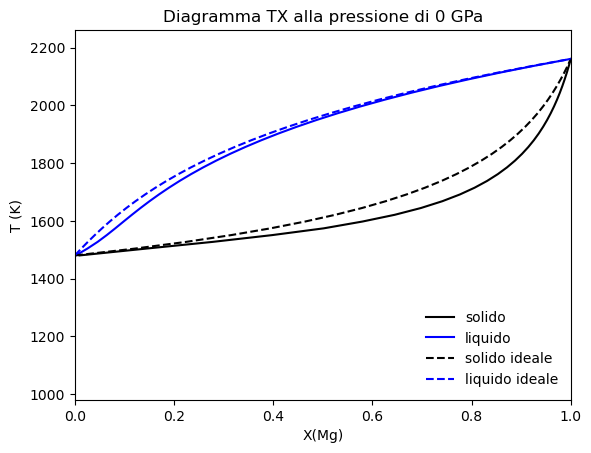


  T (K)  X(Mg)sol  X(Fe)sol  X(Mg)liq  X(Fe)liq
1480.31    0.01      0.99      0.00      1.00  
1550.73    0.40      0.60      0.06      0.94  
1621.15    0.65      0.35      0.12      0.88  
1691.57    0.78      0.22      0.17      0.83  
1761.98    0.85      0.15      0.23      0.77  
1832.40    0.90      0.10      0.31      0.69  
1902.82    0.94      0.06      0.41      0.59  
1973.23    0.96      0.04      0.53      0.47  
2043.65    0.98      0.02      0.68      0.32  
2114.07    0.99      0.01      0.86      0.14  


In [3]:
melt(nt=30,nt_prt=10,ideal=True, W=8400)

Qui abbiamo fatto un calcolo a pressione 0 (il valore di default per *ip*), specificando il parametro di Margules W=8400 j/mole.

La funzione *composition* ci restituisce le composizioni e le quantità relative di fase solida e liquida a P e T fissate, per una certa composizione *globale* del sistema. Per esempio, a T=1700 K, P=0 GPa e X(Mg) totale pari a 0.40 (con W=8400 j/mole) abbiamo:

In [4]:
composition(1700,0,8400,prt=True,xval=0.4)

Pressione 0.0 GPa,  Temperatura 1700.0 K

Per una composizione X(Mg) globale pari a 0.40: 
X(Mg) fase solida 0.79, quantità fase solida 0.37
X(Mg) fase liquida 0.18, quantità fase liquida 0.63


Bene, fino a qui è *storia* già vista nelle esercitazioni precedenti. Usiamo adesso la nuova funzione *perplex*, il cui input è descritto nell'help:

In [5]:
help(perplex)

Help on function perplex in module __main__:

perplex(it, ip, inat, W, prt=False, nx=20)
    Calcola la composizione della fasi solida e liquida
    all'equilibrio, data una certa temperatura e pressione, e
    per una composizione globale del componente "a" (Mg) nel 
    sistema.
    
    Il calcolo è Perplex-like, nel senso vengono generati
    pseudocomposti dei quali viene valutata l'energia libera;
    gli pseudocomposti a minore energia libera sono quelli
    che corrispondono alle fasi effettivamente in equilibrio.
    
    Input:
        it   - temperatura (K)
        ip   - pressione   (GPa)
        inat - composizione globale componente Mg
        W    - parametro di Margules
        prt  - se True, stampa le composizioni degli pseudo-composti
               considerati (default: False)    
        nx   - densità della griglia X/Q per la ricerca numerica
               di X e Q (composizioni e quantità relative di S e L;
               default: 20)



In primo luogo, la funzione procede definendo una griglia nello spazio X/Q (composizioni delle fasi/quantità relativa delle fasi). Questo compito è assegnato alla funzione *perplex_comp*, richiamata da *perplex* che gli fornisce la composizione *globale* del sistema in termini di frazione molare X(Mg) (*inat*). La funzione *perplex_com* provvede a definire un certo numero di *pseudocomposti* con composizione X(Mg)s (frazione molare di Mg nella fase solida) e, al variare delle rispettive quantità molari *qs* e *ql* di fase solida e liquida (*qs* è l'altro asse della griglia XQ), si calcola le corrispondenti composizioni della fase liquida.

Questo calcolo procede assumendo che $q^{tot}=q^S + q^L=1$  \[una mole complessiva di $\rm (Mg,Fe)_2SiO_4$ in solido + liquido \]

- Numero di moli di Mg in solido: $n_{\rm Mg}^S = x_{\rm Mg}^S q^S$
<br><br>
- Numero di moli di Mg nella fase liquida: $n_{\rm Mg}^L = n_{\rm Mg}^{tot}-n_{\rm Mg}^S$, dove $n_{\rm Mg}^{tot}$ coincide numericamente con $x_{\rm Mg}^{tot}$ dato in input (*inat*), perchè $q^{tot}=q^S+q^L=1$ e quindi $n_{\rm Mg}^{tot}=x_{\rm Mg}^{tot}q^{tot}=x_{\rm Mg}^{tot}$.
<br><br>
- Sapendo che $q^L=1-q^S$, la composizione della fase liquida sarà: $x_{\rm Mg}^L=n_{\rm Mg}^L/q^L$ 

La griglia X/Q è costruita facendo variare $x_{\rm Mg}^S$ e $q^S$ tra 0 e 1 in *nx* punti (*nx* è un argomento opzionale di *perplex*, il cui default è pari a 20). 

Naturalmente non tutte le coppie $(x_{\rm Mg}^S, q^S)$ (i punti della griglia) sono lecite data la composizione globale $x_{\rm Mg}^{tot}$: se per esempio fosse $x_{\rm Mg}^{tot}=0.5$, avremmo 0.5 moli di Mg nel sistema complessivo $q^S+q^L$; in tal caso un punto $(x_{\rm Mg}^S, q^S)=(1,1)$, che equivale ad avere $n_{\rm Mg}^S=x_{\rm Mg}^Sq^S=1$, non sarebbe compatibile con $n_{\rm Mg}^{tot}=0.5$ (ovviamente dovrebbe essere $n_{\rm Mg}^{S} < n_{\rm Mg}^{tot}$). Tutte le coppie di punti XQ non compatibili con la composizione globale (*inat*) portano a valori di $x_{\rm Mg}^L$ fuori dall'intervallo \[0,1\] (una frazione molare è, per definizione, compresa tra 0 e 1...) e sono quindi scartate dalla funzione *perplex_comp*.

Il codice della funzione *perplex_comp* è mostrato nella cella successiva

In [6]:
print(ins.getsource(perplex_comp))

def perplex_comp(inat,nx):
    '''
    Calcola le possibili composizioni degli pseudocomposti
    e le abbondanze relative delle due fasi in equilibrio, a 
    partire da una fissata composizione globale del componente "a" (Mg)
    
    Input: 
        inat - composizione globale del componente "a"
        nx   - densità della griglia X/Q per la ricerca numerica
               di X e Q (composizioni e quantità relative di S e L)
    '''
    
    xas=np.linspace(0.001,0.999,nx)
    qs=np.linspace(0.001,0.999,nx)
    
    xas_l=np.array([])
    xal_l=np.array([])
    qs_l=np.array([])
    ql_l=np.array([])
    chk_l=np.array([])
    
    for ixas in xas:        # loop sulle composizioni X(Mg) in S
        for iqs in qs:      # loop sulle moli di fase S
            nas=iqs*ixas    # moli di Mg in S
            nal=inat-nas    # moli di Mg in L
            iql=1-iqs       # moli di fase L
            ixal=nal/iql    # composizione X(Mg) in L
            
            # Controlli:
          

Ottenuta la griglia da *perplex_comp*, la funzione *perplex* calcola l'energia libera complessiva per ogni punto XQ della griglia, secondo l'equazione:

$$\mu(x,q) = q^S\mu(x^S)+q^L\mu(x^L)$$

Si noti che, in ogni fase, $x_{\rm Fe}=1-x_{\rm Mg}$. La funzione *perplex* è riportata nella cella seguente:

In [7]:
print(ins.getsource(perplex))

def perplex(it,ip,inat,W,prt=False,nx=20):
    '''
    Calcola la composizione della fasi solida e liquida
    all'equilibrio, data una certa temperatura e pressione, e
    per una composizione globale del componente "a" (Mg) nel 
    sistema.
    
    Il calcolo è Perplex-like, nel senso vengono generati
    pseudocomposti dei quali viene valutata l'energia libera;
    gli pseudocomposti a minore energia libera sono quelli
    che corrispondono alle fasi effettivamente in equilibrio.
    
    Input:
        it   - temperatura (K)
        ip   - pressione   (GPa)
        inat - composizione globale componente Mg
        W    - parametro di Margules
        prt  - se True, stampa le composizioni degli pseudo-composti
               considerati (default: False)    
        nx   - densità della griglia X/Q per la ricerca numerica
               di X e Q (composizioni e quantità relative di S e L;
               default: 20)       
    '''
    xas_l, xal_l,qs_l,ql_l,chk_l=perplex_comp(inat

Le due istruzioni *chiave* di *perplex* sono

```
xas_l, xal_l,qs_l,ql_l,chk_l=perplex_comp(inat,nx)
mu_l=perplex_g(it,ip,xas_l,xal_l,qs_l,ql_l,W)
```

La prima istruzione chiama *perplex_comp* per ottenere la griglia XQ; la seconda calcola l'energia di Gibbs alla *T* e *P* fissata e per tutti i nodi *leciti* della griglia, le cui *coordinate* sono conservate nelle liste *xas_l*  (lista di $x_{\rm Mg}^S$), *xal_l*  ($x_{\rm Mg}^L$), *qs_l*  ($q^S$) e *ql_l*  ($q^L$). Per ogni punto, *G* è calcolata usando la funzione *perplex_g*.

<br>

Usiamo *perplex* per fare un calcolo a T=1700 K, P=0 GPa e $x_{\rm Mg}^{tot}=0.40$ (con parametro di Margules W=8400 j/mole): 

Calcolo Perplex-like
Temperatura: 1700.0 K,  Pressione:  0.0 GPa
Composizione globale X(Mg) pari a 0.40
X(Mg) fase solida 0.79, quantità fase solida 0.37
X(Mg) fase liquida 0.17, quantità fase liquida 0.63


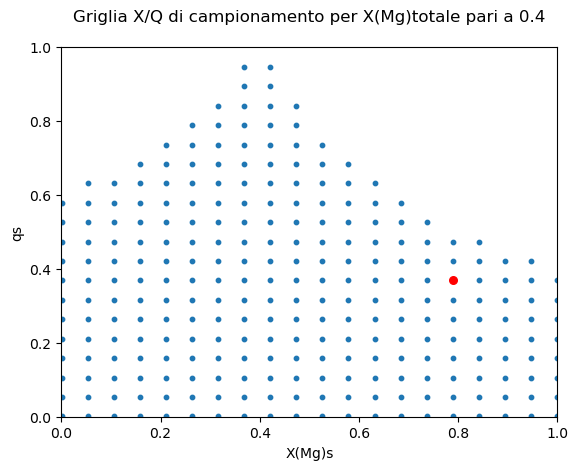

In [8]:
perplex(1700,0,0.40,8400)

La funzione fornisce anche una visualizzazione della griglia di punti XQ che è stata definita. Il marker in rosso identifica il punto della griglia che ha la più bassa energia libera e che quindi corrisponde alla situazione all'equilibrio. 

Notate come il risultato sia praticamente identico a quello ottenuto con la funzione *composition* che usava una strategia di calcolo differente.

Nel caso specifico, l'algoritmo *perplex* è molto più lento rispetto a quello implementato in *composition*. I tempi di esecuzione sono stimabili con la funzione *time* (funzione di sistema di Python):

In [9]:
time(composition(1700,0,8400,prt=True,xval=0.4))

Pressione 0.0 GPa,  Temperatura 1700.0 K

Per una composizione X(Mg) globale pari a 0.40: 
X(Mg) fase solida 0.79, quantità fase solida 0.37
X(Mg) fase liquida 0.18, quantità fase liquida 0.63
CPU times: total: 31.2 ms
Wall time: 33.9 ms


la funzione *time* esegue *composition* con il suo input, e scrive come ultima riga dell'output, il tempo di esecuzione (*Wall time*, che è il tempo complessivo di esecuzione). Qui abbiamo un tempo di esecuzione intorno ai 30 ms (millisecondi).

Con l'algoritmo *perplex* i tempi di calcolo sono ben più lunghi: 

Calcolo Perplex-like
Temperatura: 1700.0 K,  Pressione:  0.0 GPa
Composizione globale X(Mg) pari a 0.40
X(Mg) fase solida 0.79, quantità fase solida 0.37
X(Mg) fase liquida 0.17, quantità fase liquida 0.63


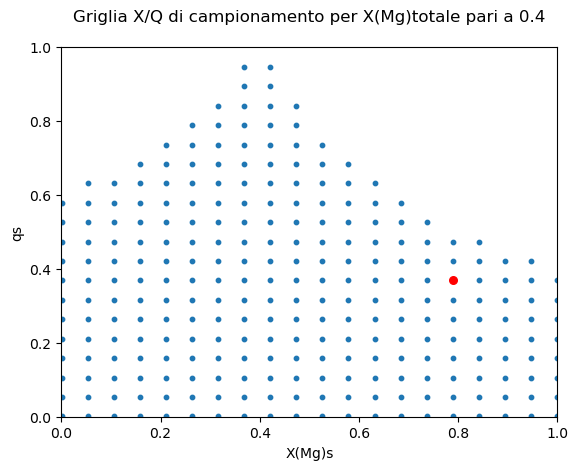

CPU times: total: 2.67 s
Wall time: 2.67 s


In [10]:
time(perplex(1700,0,0.40,8400))

siamo intorno ai 2.7 secondi. L'argoritmo *perplex* è meno efficiente dal punto di vista computazionale (tempi di calcolo lunghi), inoltre l'accuratezza dei risultati dipende dalla densità della griglia: tanti più punti abbiamo nella griglia, tanto maggiore è l'accuratezza del calcolo, ma tanto più aumenta il tempo di calcolo. Proviamo a rifare lo stesso calcolo passando da *nx*=20 (il default) a *nx*=40:  

Calcolo Perplex-like
Temperatura: 1700.0 K,  Pressione:  0.0 GPa
Composizione globale X(Mg) pari a 0.40
X(Mg) fase solida 0.79, quantità fase solida 0.36
X(Mg) fase liquida 0.18, quantità fase liquida 0.64


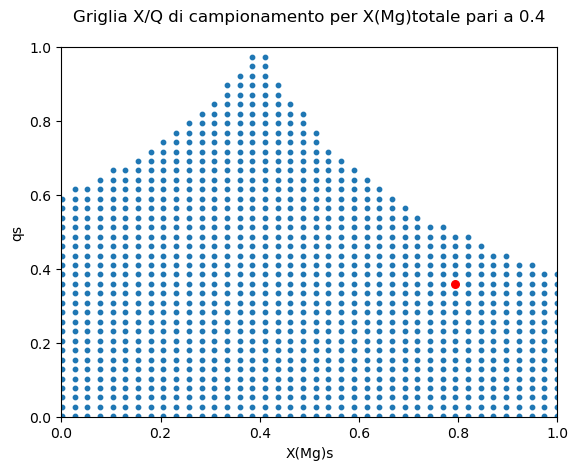

CPU times: total: 10.3 s
Wall time: 10.3 s


In [11]:
time(perplex(1700,0,0.40,8400,nx=40))

Siamo passati da circa 3 secondi a 10 secondi... 

Tuttavia l'algoritmo *perplex* è quello usato nel programma *PerpleX* di Connolly perchè è molto più facile da implementare per un numero in generale molto alto di fasi da prendere *simultaneamente* in considerazione e per una chimica a molte componenti (nei nostri esempi abbiamo solo due fasi e due componenti...). In tal caso le tecniche di minimizzazione di una funzione (*G*) in uno spazio *N*-dimensionale (dove *N* diventa un numero molto grande al crescere della complessità chimica del sistema) come quelle usate in *composition*,  diventano praticamente inapplicabili. Inoltre *PerpleX* è magistralmente *ottimizzato* per funzionare *velocemente* (ed è anche un programma scritto in un linguaggio *compilato* e non *interpretato* come Python, ma sorvoliamo su questi *dettagli*): i tempi di calcolo sono ben inferiori a quelli dati qui, per un sistema così semplice.     